# **In-processing technique: A Reductions Approach to Fairness for Statistical Parity**

The Reductions approach (Agarwal et al 2018) makes use of constrained optimisation to reduce binary classification to a series of cost-sensitive, weighted classification problems. The optimal solution is then an equilibrium between two min max expressions. The steps we will take are outlined below.

1. First, we will calculate fairness metrics for a base classifier
2. We will then apply the Reductions method to train a predictive model and observe the results.

# Install Libraries and load data

In [ ]:
# install AIF360
!pip install aif360
!pip install fairlearn

import pickle
import pandas as pd
import numpy as np
import seaborn as sns

from fairlearn.metrics import MetricFrame
from fairlearn.metrics import demographic_parity_difference
from fairlearn.metrics import equalized_odds_difference
from fairlearn.metrics import false_negative_rate_difference
from fairlearn.reductions import DemographicParity
from fairlearn.reductions import EqualizedOdds
from fairlearn.reductions import ExponentiatedGradient

from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import RidgeClassifier


Load the data into a dataframe using pickle.load

In [ ]:
# load data (amend this code to load the data from the correct file location)

with open(<filename>, 'rb') as handle:
    df = pickle.load(handle)


In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,Gender_Female,Gender_Male,Ethnicity_Asian,Ethnicity_Black,Ethnicity_Hispanic,Ethnicity_White,Action
0,28.021737,4.351153,2.453895,1.637143,-1.746628,-0.483463,0.034170,1.399225,-0.795440,0.417474,0.214564,-0.471581,1.945645,-0.676217,1.213878,0.015701,1.472670,-0.054158,0.106858,-1.073194,-1.071848,-0.249942,0.634626,-0.732358,2.445728,0.784284,0.112329,1.055362,-0.605459,1.259140,-0.287927,0.214142,-0.644585,1.165376,-0.409198,-0.705823,0.091147,-0.953603,0.979086,0.745246,...,-0.178814,-0.145229,-0.040692,-0.046980,0.311939,-0.348202,0.271357,0.355443,-0.050447,-0.051816,0.083028,0.184139,0.107824,-0.083415,-0.359288,0.156547,-0.588539,-0.025777,-0.172269,0.331421,0.222768,-0.319124,-0.060476,-0.557444,-0.015627,-0.052749,-0.234189,-0.072384,0.090403,0.376761,0.258914,-0.050558,0.014513,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,29.603342,-3.407193,0.771800,-2.957411,0.599226,-2.805277,0.329414,-2.055339,-1.194446,-0.633159,2.268302,1.159443,0.899266,-0.472739,0.541605,-1.248643,0.046512,1.225688,0.456477,-1.483071,-0.944882,1.483229,0.512809,0.692537,0.178988,-1.609531,-1.985852,-0.469491,-1.156583,0.475535,-0.041015,-0.214832,-0.681641,1.131433,-0.667814,0.267111,-0.112433,1.094115,0.647188,0.134436,...,-0.108402,0.027760,-0.015238,0.027453,0.319960,-0.014589,-0.083241,-0.285702,0.047510,-0.144107,0.405289,-0.044139,-0.287215,0.201876,-0.298703,0.347969,0.029646,0.073052,-0.010259,0.023681,0.373202,-0.525402,-0.198727,-0.198440,-0.158843,0.191984,-0.004532,0.229210,-0.173042,-0.072871,0.442939,-0.054423,0.026959,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,26.504283,0.642464,2.522944,-2.197094,2.270646,-0.472510,0.532815,-0.266449,-0.131638,1.038315,-0.865827,-0.811267,-0.381401,-0.801701,-0.485021,0.656005,2.489571,-0.714447,0.658228,-0.075957,-1.159888,-2.334786,-0.253364,-2.073697,-0.939994,-1.177166,0.551689,-1.313316,-0.486217,0.732130,-0.320456,-1.143053,1.297522,-0.617038,0.340978,0.978603,0.398515,0.068011,-0.156836,-0.995878,...,-0.101136,0.042583,0.061005,0.304137,0.259210,-0.022425,0.138097,-0.442536,-0.108350,0.369865,0.151049,0.096285,0.013651,0.175281,0.144344,-0.006250,0.100850,-0.051642,0.122977,-0.088661,-0.229844,-0.272144,0.012633,0.423352,-0.033844,-0.125387,-0.483924,-0.116553,-0.113281,0.015519,0.017111,-0.012309,0.264572,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,25.012088,0.895121,-2.092517,3.687830,0.539642,1.988930,1.121646,2.255337,-0.128801,1.148379,1.616247,-2.599757,-0.322807,2.102508,-0.204551,0.069818,0.745222,-0.859875,-2.235995,-0.207436,-1.678697,-0.569024,-0.723122,-0.144833,-1.537487,1.678429,0.501249,-0.230747,0.746559,-0.069959,-0.346651,0.448291,0.283592,-0.445759,-0.529080,0.287333,0.466766,-0.411191,0.158602,-0.112038,...,-0.092894,-0.009915,-0.031731,0.153983,0.001281,0.123019,-0.035719,-0.045633,-0.103204,0.089567,0.104990,0.337228,-0.018783,-0.215437,0.268139,-0.125425,0.095183,-0.125172,-0.226467,0.371647,-0.023041,-0.093040,0.338300,-0.280392,0.046582,0.116709,0.133876,0.072716,0.124083,0.213735,-0.149901,-0.217130,0.004403,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,27.358934,-2.332423,0.154999,-2.623793,1.682456,1.262280,-1.685565,0.489319,-0.043471,-0.372265,1.778535,-1.145419,2.461327,1.396318,-0.911969,-2.228570,1.378633,-1.512325,-0.440331,-0.111163,-0.885884,-0.840501,1.576620,-0.972075,-2.008346,-0.358732,0.896535,0.562193,0.154542,-1.077315,1.902062,1.728109,0.317205,-0.436143,0.226549,-0.502206,-0.157102,-0.858722,-0.537544,-0.715195,...,0.039836,-0.168277,0.077232,0.193722,0.093298,-0.075132,-0.063202,0.120167,0.039270,0.350429,0.166559,0.130134,-0.181019,-0.193276,0.312204,-0.187331,-0.029194,-0.212277,-0.463872,0.041810,0.041185,-0.182479,-0.182461,-0.019350,-0.093371,0.003443,-0.025467,0.155397,-0.067609,-0.084833,0.033429,-0.199198,0.229629,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,.

# Run a baseline predictive model without applying a fairness technique
First we will build a standard Ridge Classifier and observe some baseline results, using the original data and without a fairness technique.

Train a Ridge Classifier with 10 fold stratified cross validation. Compute performance metrics (Accuracy, Precision, Recall and F1 Score) and fairness metrics (Equalized Odds Difference, False Negative Rate Difference, and Statistical Parity Difference)

This base code for the ridge regression classifier is provided for you. There are no gaps to fill in in this sections.

In [ ]:
# Instantiate the classifier

model = RidgeClassifier()

# instantiate the cross-validation scheme
mv = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

# setup the performance metrics to be computed
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score, 
                "F1-Score": metrics.f1_score, 
                }


In [ ]:
# Train a baseline ridge regression classifier on the dataset before applying the Reductions method
k, i = True, 1

# instantiating X
X = df.drop(labels=df.columns[-1], axis=1)

# instantiating the target variable
y = df[df.columns[-1]]

# 10 fold CV
for (train, test) in mv.split(X, y):

    # fit model
    X_train = X.iloc[train].copy()
    y_train = y.iloc[train].copy()
    model = model.fit(X_train, y_train)
    
    # get predictions in the test set
    ypred_class = model.predict(X.iloc[test])

    # compute performance metrics
    metrics = []
    X_test = X.iloc[test].copy()
    y_test = y.iloc[test].copy()
    white = X_test['Ethnicity_White']
    for pf in perf_metrics.keys():
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]
    spd = demographic_parity_difference(y_test, ypred_class, sensitive_features=white)
    eod = equalized_odds_difference(y_test, ypred_class, sensitive_features=white)
    fnrd = false_negative_rate_difference(y_test, ypred_class, sensitive_features=white)
    
    # Compute fairness metrics
    metrics += [['Statistical Parity Difference', spd]]
    metrics += [['Equalized Odds Difference', eod]]
    metrics += [['False Negative Rate Difference', fnrd]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics_orig = df_m.copy()
        k=0
    else:
        df_metrics_orig = pd.concat([df_metrics_orig, df_m.copy()], axis=0, ignore_index=True)

In [ ]:
# Display metrics

metrics_table_orig = df_metrics_orig.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
metrics_table_orig

,mean,std
,Value,Value
Metric,,
Accuracy,0.712501,0.007711
Equalized Odds Difference,0.069589,0.025648
F1-Score,0.589124,0.012598
False Negative Rate Difference,0.065355,0.031358
Precision,0.653016,0.012121
Recall,0.536745,0.015263
Statistical Parity Difference,0.063249,0.012323


# Use the Reductions approach to target Statistical Parity

Amend your Ridge Classifier routine above to apply the Reductions approach when training the model. Compute performance metrics (Accuracy, Precision, Recall and F1 Score) and fairness metrics (Equalized Odds Difference, False Negative Rate Difference, Statistical Parity Difference)

In [ ]:
# Train a ridge regression classifier on the dataset before reweighing
model = RidgeClassifier()
k, i = True, 1

# instantiating X
X = df.drop(labels=df.columns[-1], axis=1)

# instantiating the target variable
y = df[df.columns[-1]]

# 10 fold cv
for (train, test) in mv.split(X, y):

    # fit reductions in-processor
    X_train = X.iloc[train].copy()
    y_train = y.iloc[train].copy()

    # TODO: Set up the in-processor

    # /TODO

    # TODO: Get predictions in the test set

    # /TODO

    # compute performance metrics
    metrics = []
    y_test = y.iloc[test].copy()
    white = X_test['Ethnicity_White']
    for pf in perf_metrics.keys():
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]
    spd = demographic_parity_difference(y_test, ypred_class, sensitive_features=white)
    eod = equalized_odds_difference(y_test, ypred_class, sensitive_features=white)
    fnrd = false_negative_rate_difference(y_test, ypred_class, sensitive_features=white)
    
    # Compute fairness metrics
    metrics += [['Statistical Parity Difference', spd]]
    metrics += [['Equalized Odds Difference', eod]]
    metrics += [['False Negative Rate Difference', fnrd]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

In [ ]:
# Display metrics

metrics_table_rw = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
metrics_table_rw

,mean,std
,Value,Value
Metric,,
Accuracy,0.713618,0.008646
Equalized Odds Difference,0.031013,0.023050
F1-Score,0.590904,0.013979
False Negative Rate Difference,0.029202,0.025131
Precision,0.654590,0.013156
Recall,0.538620,0.016246
Statistical Parity Difference,0.015548,0.010478


# Present results to show the effectiveness of the Reductions method in Achieving Statistical Parity

Present graphs (bar charts work well) to show how each performance and fairness metric differs for the baseline model compared with the application of the reductions method. Show the target line for each metric on the graph.

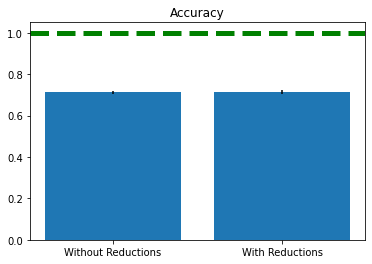

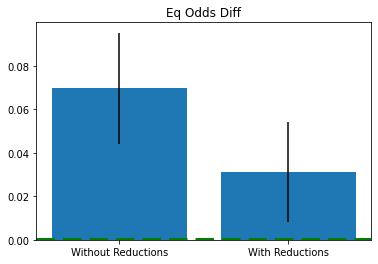

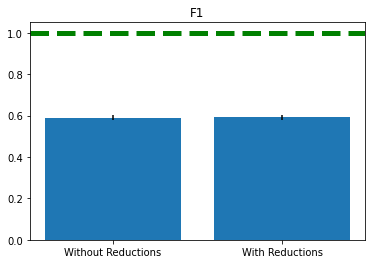

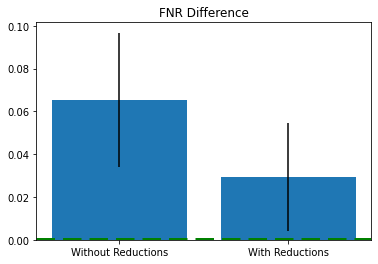

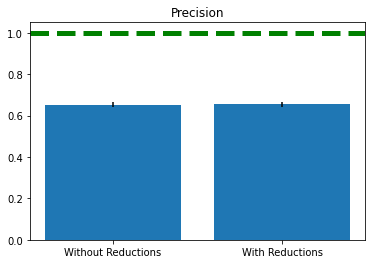

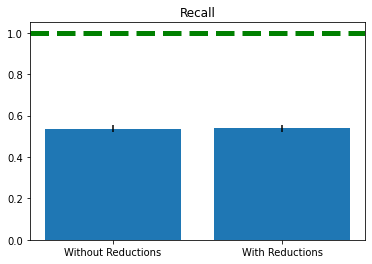

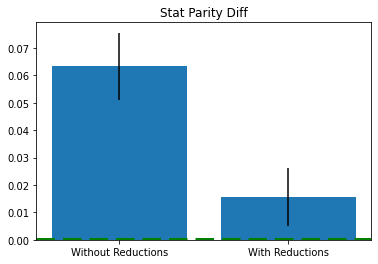

In [ ]:
# TODO: Present graphs

# /TODO
